This notebook contains practical 1 - 3 on the small dataset.

Notebook titled `main.ipynb` contains Practical 4 'Going Big' (i.e training on the 25M dataset)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings


%matplotlib inline
warnings.filterwarnings("ignore")

### Loading the dataset:

In [8]:
ml_25m_path = "./ml-25M/ml-25m"
ml_small_path = "./ml-latest-small"

In [10]:
movies_df = pd.read_csv(f'{ml_small_path}/movies.csv')

ratings_df = pd.read_csv(f'{ml_small_path}/ratings.csv')


In [12]:
ratings_df = ratings_df.drop('timestamp', axis=1)

In [13]:
movies_df.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [14]:
ratings_df.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


# Pratical 1:

### Data structure to Index data :
- by User
- by Movie

In [ ]:
# Get unique lists of movies and users
movies = ratings_df["movieId"].unique().tolist()
users = ratings_df["userId"].unique().tolist()

# Creating mappings 
idx_to_movieid = movies.copy()  
idx_to_userid = users.copy()    

movieid_to_idx = dict(enumerate(movies))  
userid_to_idx = dict(enumerate(users))    

#  id->index mapping
movieid_to_idx = {v: k for k, v in movieid_to_idx.items()}
userid_to_idx = {v: k for k, v in userid_to_idx.items()}

In [ ]:
# Getting all data at once using DataFrame operations
user_movie_ratings = ratings_df[['userId', 'movieId', 'rating']].values

# Initializing lists with known sizes
n_users = ratings_df["userId"].nunique()
n_movies = ratings_df["movieId"].nunique()
user_data_list = [[] for _ in range(n_users)]
movie_data_list = [[] for _ in range(n_movies)]

for user_id, movie_id, rating in user_movie_ratings:
    user_idx = userid_to_idx[user_id]
    movie_idx = movieid_to_idx[movie_id]
    user_data_list[user_idx].append((movie_idx, rating))
    movie_data_list[movie_idx].append((user_idx, rating))

print(f"Length of user_data_list: {len(user_data_list)}")
print(f"Length of movie_data_list: {len(movie_data_list)}")

Length of user_data_list: 610
Length of movie_data_list: 9724


In [25]:
user_data_list = [np.array(data) for data in user_data_list]
movie_data_list = [np.array(data) for data in movie_data_list]

#### Plot rating distributions of data

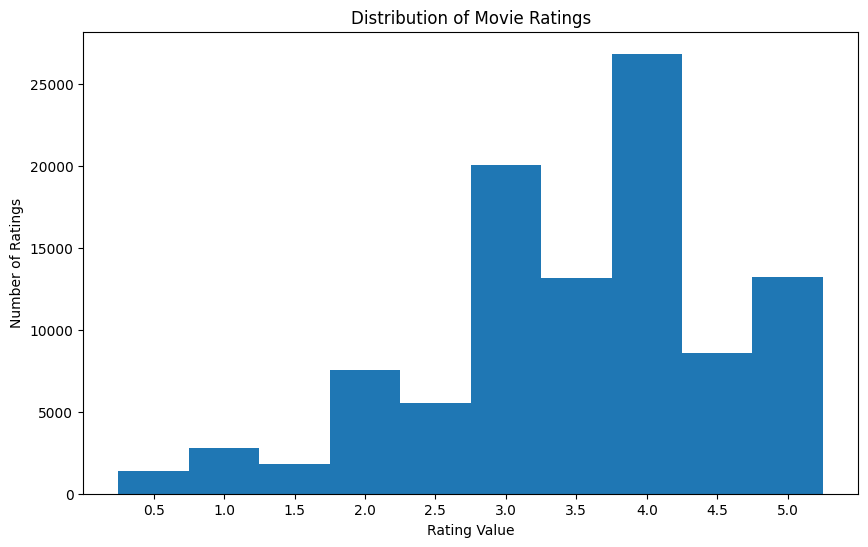

In [ ]:
rating_counts = ratings_df['rating'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, 
        height=rating_counts.values, 
        width=0.5, 
        align='center')

plt.xticks(rating_counts.index)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Number of Ratings')

plt.savefig('./assets/small-dataset/ratings_distribution.pdf', bbox_inches='tight')
plt.show()
plt.close()

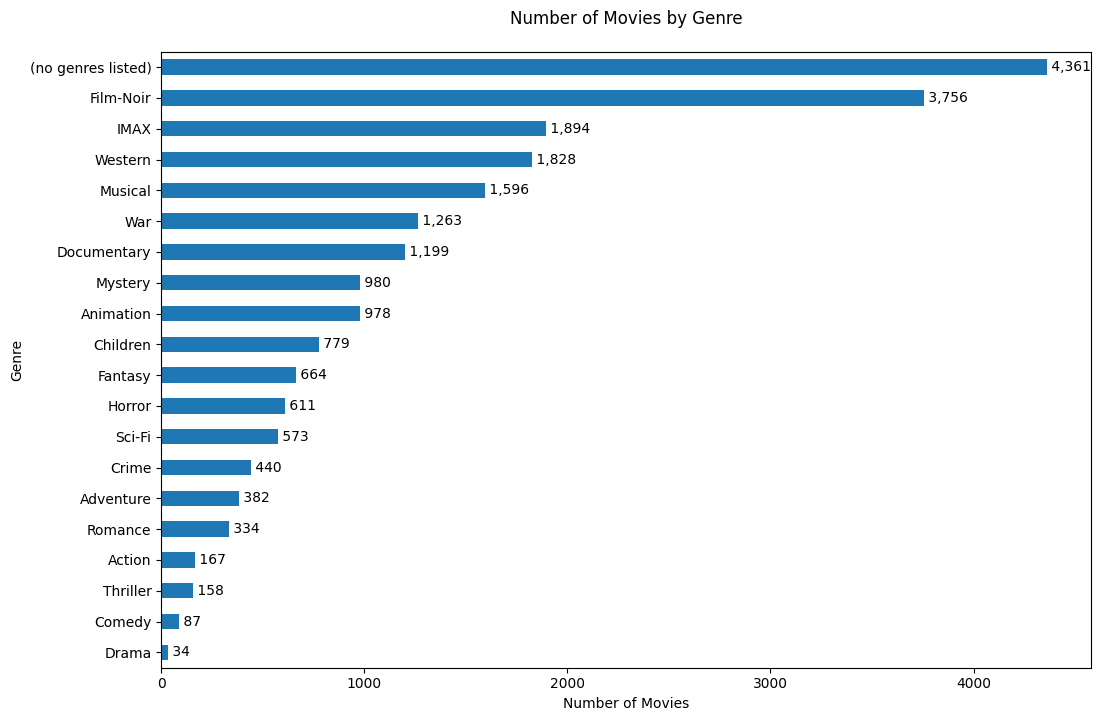

In [ ]:
genre_counts = pd.Series('|'.join(movies_df['genres']).split('|')).value_counts()


plt.figure(figsize=(12, 8))

# Creating horizontal bar plot
ax = genre_counts[::-1].plot(kind='barh')

for i, v in enumerate(genre_counts[::-1]):
    ax.text(v, i, f' {v:,}', va='center')  

plt.title('Number of Movies by Genre', pad=20)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

plt.yticks(range(len(genre_counts)), genre_counts.index)

# Saving the plot to directory
plt.savefig('./assets/small-dataset/Number_of_movies_by_genre.pdf', bbox_inches='tight')
plt.show()
plt.close()

#### Checking for Power laws

In [ ]:
def power_law(save_file_path):
   # Calculate ratings counts
   user_rating_counts = ratings_df.groupby('userId')['rating'].count()
   movie_rating_counts = ratings_df.sort_values(by=['movieId']).groupby('movieId')['rating'].count()

   # Getting distributions
   user_degrees = user_rating_counts.value_counts().sort_index()
   movie_degrees = movie_rating_counts.value_counts().sort_index()

   # subplot figure
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

   # User ratings plot
   ax1.scatter(user_degrees.index, user_degrees.values, color='blue', alpha=0.5)
   ax1.set_xscale('log')
   ax1.set_yscale('log')
   ax1.set_xlabel('Number of Ratings per User (log scale)')
   ax1.set_ylabel('Number of Users (log scale)') 
   ax1.set_title('Distribution of User Ratings')
   ax1.grid(True)

   # Movie ratings plot
   ax2.scatter(movie_degrees.index, movie_degrees.values, color='green', alpha=0.5)
   ax2.set_xscale('log')
   ax2.set_yscale('log')
   ax2.set_xlabel('Number of Ratings per Movie (log scale)')
   ax2.set_ylabel('Number of Movies (log scale)')
   ax2.set_title('Distribution of Movie Ratings')
   ax2.grid(True)

   plt.tight_layout()
   
   # Saving plots
   plt.savefig(save_file_path, bbox_inches='tight')

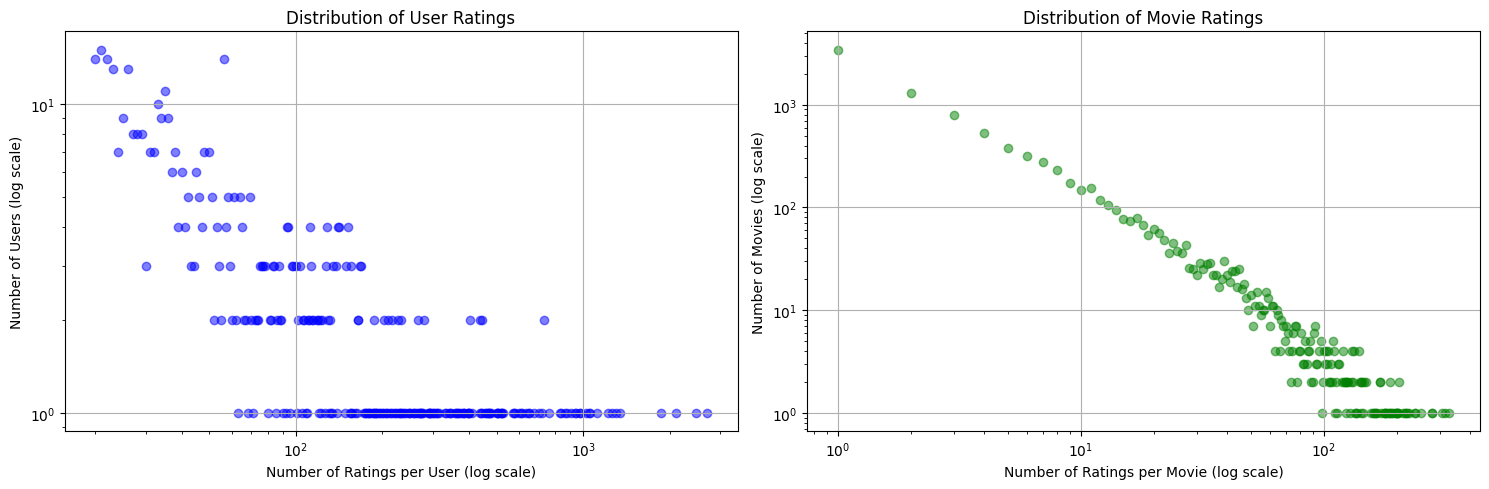

In [37]:
power_law('./assets/small-dataset/powerlaw.pdf')

There are indeed power laws in the data

# Pratical 2

### A model with biases only

#### Splitting into train and test set:

In [46]:
key = np.random.default_rng(0)
user_ids = ratings_df['userId'].tolist()
movie_ids = ratings_df['movieId'].tolist()
ratings = ratings_df['rating'].tolist()
train_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
test_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
train_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]
test_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]

for user_id, movie_id, rating in zip(user_ids, movie_ids, ratings):
  if key.uniform(0, 1) < 0.8:
    train_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    train_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))
  else:
    test_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    test_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))


print("Length of train_user_data_list:", len(train_user_data_list))
print("Length of test_user_data_list:", len(test_user_data_list))
print("Length of train_user_data_list:", len(train_movie_data_list))
print("Length of test_user_data_list:", len(test_movie_data_list))

Length of train_user_data_list: 610
Length of test_user_data_list: 610
Length of train_user_data_list: 9724
Length of test_user_data_list: 9724


In [47]:
train_user_data_list = [np.array(data) for data in train_user_data_list]
test_user_data_list = [np.array(data) for data in test_user_data_list]
train_movie_data_list = [np.array(data) for data in train_movie_data_list]
test_movie_data_list = [np.array(data) for data in test_movie_data_list]

In [ ]:
from tqdm.auto import tqdm

# Constants
M = len(user_data_list)
N = len(movie_data_list)
k = 10
iterations = 100
lambda_ = 1
gamma = 0.0001

# Initializing biases and tracking metrics
user_biases = np.zeros(M)
item_biases = np.zeros(N)
train_losses = []
train_errors = []
test_losses = []
test_errors = []

# Training Loop
for i in range(iterations):
    # Update user biases
    for m, user_data in enumerate(train_user_data_list):
        if user_data.size > 0:  # Check if user has data
            ratings = user_data[:, 1]
            indices = user_data[:, 0].astype(int)
            user_biases[m] = lambda_ * np.sum(ratings - item_biases[indices]) / (lambda_ * len(indices) + gamma)

    # Update item biases
    for q, movie_data in enumerate(train_movie_data_list):
        if movie_data.size > 0:  # Check if movie has data
            ratings = movie_data[:, 1]
            indices = movie_data[:, 0].astype(int)
            item_biases[q] = lambda_ * np.sum(ratings - user_biases[indices]) / (lambda_ * len(indices) + gamma)


    # Compute training loss and RMSE and test RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m, train_user_data in enumerate(train_user_data_list):
        if train_user_data.size > 0:  # Check if user has data
            ratings = train_user_data[:, 1]
            indices = train_user_data[:, 0].astype(int)
            residuals = ratings - user_biases[m] - item_biases[indices]
            train_error_squared += np.sum(residuals**2)
            train_size += len(ratings)

    for j, test_user_data in enumerate(test_user_data_list):
        if test_user_data.size > 0:  # Check if user has data
            ratings = test_user_data[:, 1]
            indices = test_user_data[:, 0].astype(int)
            residuals = ratings - user_biases[j] - item_biases[indices]
            test_error_squared += np.sum(residuals**2)
            test_size += len(ratings)

    train_loss = -0.5 * lambda_ * train_error_squared - 0.5 * gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))
    train_error = np.sqrt(train_error_squared / train_size)

    # Tracking train metrics
    train_losses.append(-train_loss)
    train_errors.append(train_error)

    test_loss = -0.5 * lambda_ * test_error_squared - 0.5 * gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))
    test_error = np.sqrt(test_error_squared / test_size)

    # Tracking test metrics
    test_losses.append(-test_loss)
    test_errors.append(test_error)

    print(f"Train Loss: {-train_loss:.2f} | Test Loss: {-test_loss:.2f} | Train RMSE: {train_error:.4f} | Test RMSE: {test_error:.4f}")



Train Loss: 25703.52 | Test Loss: 8057.25 | Train RMSE: 0.7974 | Test RMSE: 0.8977
Train Loss: 24594.17 | Test Loss: 7811.66 | Train RMSE: 0.7800 | Test RMSE: 0.8839
Train Loss: 24507.85 | Test Loss: 7815.44 | Train RMSE: 0.7787 | Test RMSE: 0.8841
Train Loss: 24498.96 | Test Loss: 7824.01 | Train RMSE: 0.7785 | Test RMSE: 0.8846
Train Loss: 24497.77 | Test Loss: 7828.10 | Train RMSE: 0.7785 | Test RMSE: 0.8848
Train Loss: 24497.56 | Test Loss: 7829.91 | Train RMSE: 0.7785 | Test RMSE: 0.8849
Train Loss: 24497.52 | Test Loss: 7830.73 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Train Loss: 24497.51 | Test Loss: 7831.11 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Train Loss: 24497.51 | Test Loss: 7831.30 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Train Loss: 24497.51 | Test Loss: 7831.39 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Train Loss: 24497.51 | Test Loss: 7831.43 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Train Loss: 24497.51 | Test Loss: 7831.45 | Train RMSE: 0.7785 | Test RMSE: 0.8850
Trai

In [42]:
def plot_and_save_loss(array_to_plot, filename, ylabel):
    
    plt.figure(figsize=(8, 6))
    plt.plot(array_to_plot, color='blue', linewidth=2)
    plt.xlabel('Number of Iterations', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()


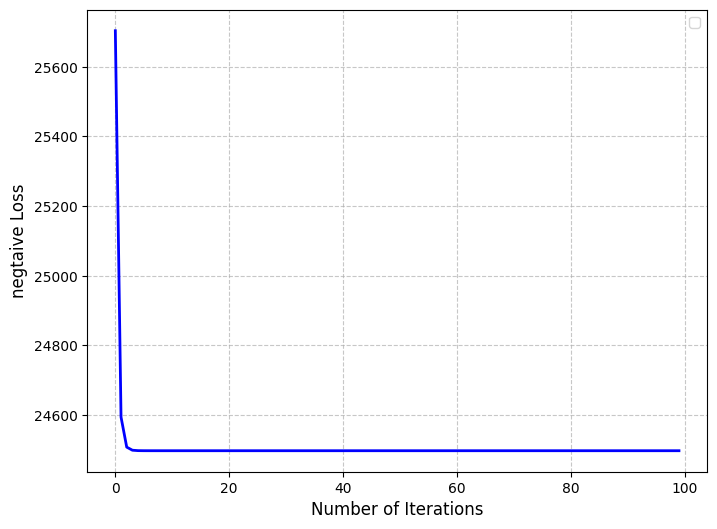

In [51]:
plot_and_save_loss(train_losses, './assets/small-dataset/train_neg_loss.pdf', 'negtaive Loss')

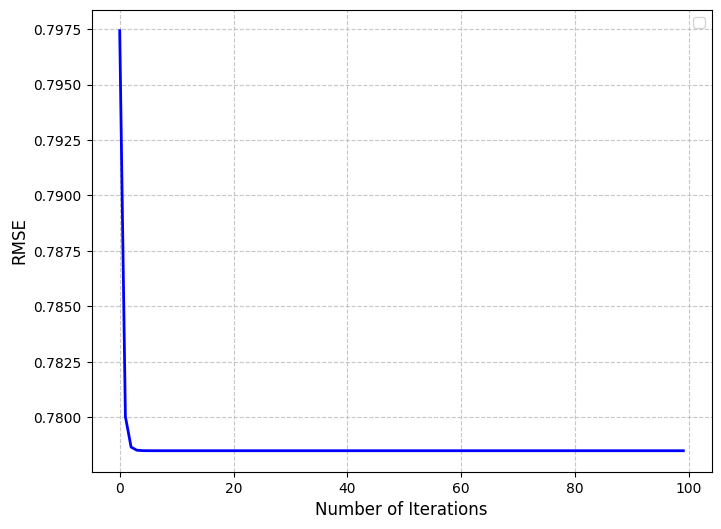

In [52]:
plot_and_save_loss(train_errors, './assets/small-dataset/train_neg_rmse.pdf', 'RMSE')

The training error converges to  0.7785

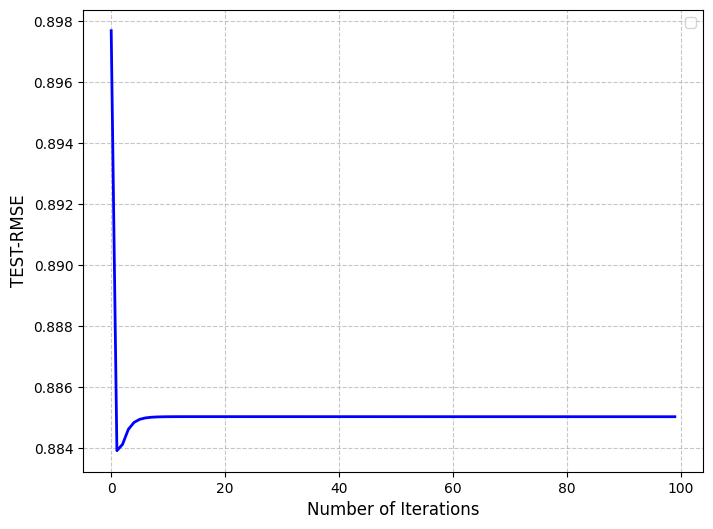

In [53]:
plot_and_save_loss(test_errors, './assets/small-dataset/test_neg_rmse.pdf', 'TEST-RMSE')

The test error converges to 0.8850, it doesn't striclty follow the train error

# Practical 3

### A model with embeddings

In [ ]:
M = len(train_user_data_list)
N = len(train_movie_data_list)
k=10
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses_k=[]
test_losses_k=[]
train_errors_k=[]
test_errors_k=[]
iter = 100
lambda_ = 1
gamma = 0.001
tau = 1

In [ ]:
for i in range(iter):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lambda_ * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lambda_ * len(indices) + gamma)
            user_biases[m] = user_bias

            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Updating user factor
            user_latent_vectors[m] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lambda_ * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lambda_ * len(indices) + gamma)
            item_biases[n] = item_bias

            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            # Updating item factor
            item_latent_vectors[n] = np.linalg.solve(lambda_ * left + tau * np.eye(k), lambda_ * right)

    # Calculate training and testing loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    train_loss = -0.5 * lambda_ * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    train_losses_k.append(-train_loss)
    train_errors_k.append(train_error)

    test_loss = -0.5 * lambda_ * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    test_losses_k.append(-test_loss)
    test_errors_k.append(test_error)

    print(f"Train Loss: {-train_loss:.2f} | Test Loss: {-test_loss:.2f} | Train RMSE: {train_error:.4f} | Test RMSE: {test_error:.4f}")


Train Loss: 21280.46 | Test Loss: 11293.15 | Train RMSE: 0.6794 | Test RMSE: 0.9311
Train Loss: 16137.49 | Test Loss: 12332.05 | Train RMSE: 0.5671 | Test RMSE: 0.9591
Train Loss: 14426.68 | Test Loss: 12699.32 | Train RMSE: 0.5285 | Test RMSE: 0.9780
Train Loss: 13545.10 | Test Loss: 12903.57 | Train RMSE: 0.5080 | Test RMSE: 0.9896
Train Loss: 13007.05 | Test Loss: 13072.65 | Train RMSE: 0.4951 | Test RMSE: 0.9988
Train Loss: 12650.79 | Test Loss: 13223.05 | Train RMSE: 0.4863 | Test RMSE: 1.0066
Train Loss: 12399.89 | Test Loss: 13349.67 | Train RMSE: 0.4799 | Test RMSE: 1.0130
Train Loss: 12214.10 | Test Loss: 13452.62 | Train RMSE: 0.4751 | Test RMSE: 1.0182
Train Loss: 12071.43 | Test Loss: 13536.37 | Train RMSE: 0.4714 | Test RMSE: 1.0223
Train Loss: 11957.98 | Test Loss: 13606.01 | Train RMSE: 0.4684 | Test RMSE: 1.0256
Train Loss: 11864.87 | Test Loss: 13665.34 | Train RMSE: 0.4659 | Test RMSE: 1.0285
Train Loss: 11786.63 | Test Loss: 13716.86 | Train RMSE: 0.4638 | Test RMSE:

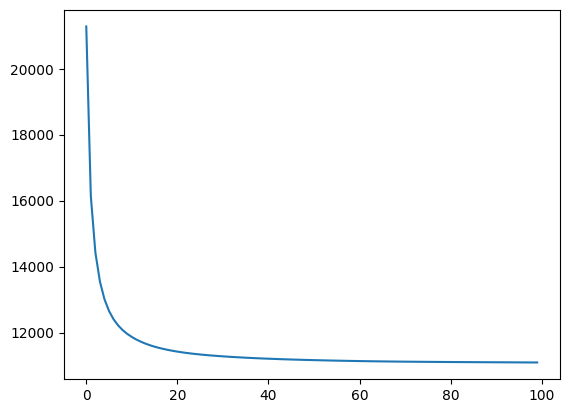

In [59]:
plt.plot(train_losses_k)

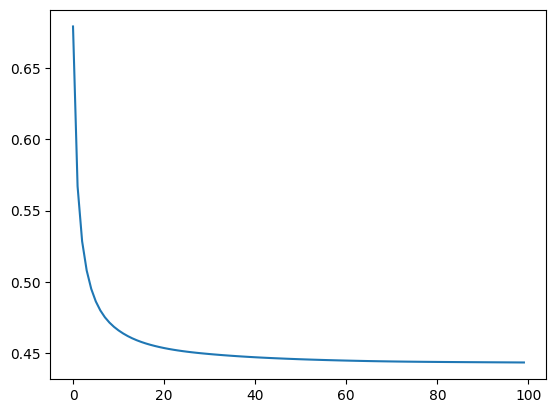

In [60]:
plt.plot(train_errors_k)